In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
import pandas as pd
import numpy as np
import tensorflow as tf
import settings
from utils import TrainingVisualizationCb

In [10]:
tf.config.list_physical_devices('GPU')

[]

### Prepare training and validation dataset split

In [11]:
def create_lstm_data(X, y, k):
    '''
    input:
        data - the numpy matrix of (n, p+1) shape, where n is the number of rows,
               p+1 is the number of predictors + 1 target column
        k    - the length of the sequence, namely, the number of previous rows 
               (including current) we want to use to predict the target.
    output:
        X_data - the predictors numpy matrix of (n-k, k, p) shape
        y_data - the target numpy array of (n-k, 1) shape
    '''
    # initialize zero matrix of (n-k, k, p) shape to store the n-k number
    # of sequences of k-length and zero array of (n-k, 1) to store targets
    X_data = np.zeros([X.shape[0]-k, k, X.shape[1]])
    y_data = []
    
    # run loop to slice k-number of previous rows as 1 sequence to predict
    # 1 target and save them to X_data matrix and y_data list
    for i in range(k, X.shape[0]):
        cur_sequence = X[i-k: i, :]
        
        X_data[i-k,:, :] = cur_sequence.reshape(1, k, X_data.shape[2])
        y_data.append(y[i-1])
    
    return X_data, np.asarray(y_data)

In [12]:
df_train = pd.read_csv("./data/train_dataset.csv")
y = df_train.pop("y").values.astype('float32')
X = df_train.values.astype('float32')
del df_train

no_rows = X.shape[0]
data_valid = X[int(no_rows*0.8):,:]
y_valid = y[int(no_rows*0.8):]
data_train = X[:int(no_rows*0.8),:]
y_train = y[:int(no_rows*0.8)]

### Define model

In [13]:
def LSTM_model(X_train, y_train, X_valid, y_valid, k):
    # Define and compile LSTM model
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(k, X_train.shape[2])))
    #model.add(Dropout(0.2))
    #model.add(LSTM(50, return_sequences = True))
    #model.add(Dropout(0.2))
    #model.add(LSTM(50, return_sequences = False))
    #model.add(Dropout(0.2))
    #model.add(LSTM(50))
    #model.add(Dropout(0.2))
    model.add(Dense(1, "tanh"))
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='mse')#,  metrics=[''])
    # Early stopping and best model checkpoint parameters
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max', verbose=2, patience=5)
    mc = tf.keras.callbacks.ModelCheckpoint('./models/best_model.h5', mode='min', verbose=2, save_best_only=True)
    viz = TrainingVisualizationCb()
    # Train the model 
    history = model.fit(X_train, y_train,
                        validation_data=(X_valid, y_valid),
                        epochs=20, verbose=2, callbacks=[mc, viz])

### Train model

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.00650, saving model to best_model.h5


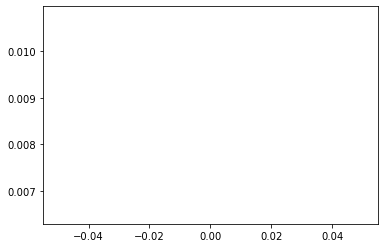

5608/5608 - 126s - loss: 0.0108 - val_loss: 0.0065 - 126s/epoch - 22ms/step
Epoch 2/20

Epoch 2: val_loss improved from 0.00650 to 0.00614, saving model to best_model.h5


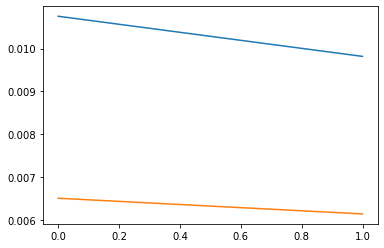

5608/5608 - 127s - loss: 0.0098 - val_loss: 0.0061 - 127s/epoch - 23ms/step
Epoch 3/20


KeyboardInterrupt: 

In [14]:
X_train, y_train = create_lstm_data(data_train, y_train, settings.SEQUENCE_LENGTH)
X_valid, y_valid = create_lstm_data(data_valid, y_valid, settings.SEQUENCE_LENGTH)

LSTM_model(X_train, y_train, X_valid, y_valid, settings.SEQUENCE_LENGTH)

### Validate

In [ ]:
from utils import plot_random

model = keras.models.load_model('./models/best_model.h5')
plot_random(X, y, 30)